# Homework 5: Effect of SARS-CoV-2 on the host organism

We will learn about the basics of gene expression data analysis. Biologists have found a way to measure how much each gene is *expressed* in each cell in an experiment. We do this by counting the number of mRNA molecules in each cell. Remember, DNA holds instructions for building proteins but can't be turned into proteins directly. Translation of DNA creates mRNA molecules which ribosomes read to synthesize proteins.
If we measure the amount of mRNA in a cell, we can tell what proteins the cell is making and, indirectly, what the cell is doing as a whole.

In [1]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

In [2]:
from Bio import SeqIO

import numpy as np

## Problem 1: Constructing the count matrix

Each single-cell gene-expression experiment takes a tissue sample containing many cells. We want to measure the amount of mRNA from a particular gene for each of those cells. We create a *gene-expression matrix*, where the rows correspond to individual cells, and the columns correspond to individual genes. So, our output will be an $N$ by $G$ matrix where $N$ is the number of cells, and $G$ is the number of genes.

A collection of cells forming a tissue must undergo special treatment before we can put it into a sequence. For instance, if we were to take all the cells, gather their mRNA material, and put this into a sequencer, we wouldn't be able to match mRNA molecules with their cell of origin. Therefore, we must attach a *cell barcode* to each cell. This barcode will be attached to all the mRNA reads coming from this cell. We will use this barcode to match mRNA molecules with their cell. The sequencer also needs to know which molecules to sequence. We only want it to sequence mRNA molecules and nothing else. Therefore, we use a special molecular primer that binds to the poly-A tail of mRNA molecules. Don't worry if you don't understand this, because it isn't crucial to us. The important thing is that each read comes with three pieces. First is the cell barcode, then the molecular primer, and then the actual mRNA fragment.

The first 12 bases of each read are the cell barcode. The following 24 bases are the oligo-dT primer, which we will discard since it carries no information. The remaining bases are the actual mRNA fragment of the gene of interest. You can find a more realistic schematic [here](https://training.galaxyproject.org/archive/2022-02-01/topics/transcriptomics/images/celseq2_schema.svg). If you want to find out more about this, [this tutorial](https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/scrna-umis/tutorial.html) seems informative.

**[TASK]**

We have prepared a collection of reads (`data/reads.fastq`) in a FASTQ file containing Phred quality scores for each nucleotide (this comes from the sequencer). We will ignore these scores in this homework. You can easily read these files using Biopython.

Your job is to take each read and determine which gene and cell it corresponds to. The reads come from SARS-CoV-2 infected tissue, so we'll be interested in which cells SARS-CoV-2 genes are expressed. We won't use NCBI for SARS-CoV-2 gene annotations this time, but we will use a more standard approach. Two files are necessary: `data/sars-cov-2.fa` is a fasta file containing the reference SARS-CoV-2 genome, and `genes.gff` contains the gene annotations in GFF format. You must use these files in this homework, as we have removed some genes to make the exercise easier.

For each read in `reads.fasq`, you must extract the cell barcode and mRNA fragment (and drop the primer). Because sequencers make mistakes and introduce errors, we'll have to run local alignment to align the fragment to each SARS-CoV-2 gene and determine the origin. For alignment, you can either adapt your implementation from HW2 or use the [`pairwise2`](https://biopython.org/docs/1.76/api/Bio.pairwise2.html) module from Biopython.

Once you align a fragment, determine the gene region of this mRNA fragment. For instance, if we have gene XYZ ranging from positions 250 to 1250 on the reference genome, a fragment that maps into this region, e.g., 450-600, can be considered an expression of this gene. Since we are constructing a count matrix, we are just counting the fragments. For instance, if the barcode is AAACCCTTT and we've mapped the read to gene XZY, we'd increase the cell in our count matrix at row AAACCCTTT and column XZY by +1.

One more important thing we must account for is possible contamination. If the tissue sample contains contamination with cells from other organisms, we might get reads that map insufficiently to our reference genome. To circumvent this, we will apply a simple threshold to our aligned reads. We will calculate the Hamming similarity of the alignments and only keep the reads that map to our reference genome with a similarity of 0.95 or higher. The Hamming similarity is just Hamming distance but counting matches instead of mismatches.

Your task is to implement four functions: `split_read`, `map_read_to_gene`, `generate_count_matrix`, and `filter_matrix` in `helper_functions.py`. Each function is worth an equal number of points. Please go through the docstrings for implementation details. Once you've implemented these functions, create a count matrix from the reads provided in `data/reads.fastq`.

**[16 points]**


*Notes:*

To keep things simple, we won't deal with RNA sequences but with DNA sequences here. We also won't have to find the reverse complement of the mRNA fragment; you can take each sequence as is and align it to the reference genome. Finally, we will assume that the cell barcodes contain no sequencing errors; sequencing errors are limited to the mRNA portion of each read.

In [3]:
from helper_functions import split_read, map_read_to_gene, generate_count_matrix, read_gff

In [4]:
# Get the reference sequence
sars_cov = SeqIO.parse(open('data/sars-cov-2.fa'), 'fasta')

for f in sars_cov:
    reference_seq = f.seq

In [5]:
# Get the gene dictionary
genes = read_gff('data/genes.gff')

In [6]:
# Get other reads
fasta_file = SeqIO.parse(open('data/reads.fastq'), 'fastq')
ids = []
reads = []

for f in fasta_file:
    ids.append(f.id)
    reads.append(str(f.seq))

In [7]:
dataframe = generate_count_matrix(reads, reference_seq, genes, 0.95)

In [8]:
print(np.sum(dataframe.values, axis=0))
print('\n')
print(dataframe)

[50. 44. 41. 51. 50. 50. 47. 40. 42. 48. 48.]


                E    M    N  ORF1a  ORF1b  ORF3a  ORF6  ORF7a  ORF7b  ORF8  \
CTCGCGAAGCTA  8.0  3.0  4.0    3.0   10.0    5.0   7.0    1.0    8.0  11.0   
CAGATGGCGCGT  5.0  4.0  2.0    3.0    5.0    6.0   7.0    6.0    2.0   9.0   
ACCCCACAGAGC  5.0  7.0  8.0    8.0    7.0    7.0   6.0    8.0    7.0   4.0   
GAGTGAATATGT  1.0  1.0  1.0    3.0    3.0    3.0   2.0    3.0    0.0   1.0   
CTACTATACGTT  0.0  1.0  1.0    1.0    3.0    0.0   0.0    2.0    4.0   1.0   
CCAACCTGGCGG  0.0  1.0  0.0    0.0    1.0    0.0   0.0    0.0    0.0   1.0   
TGGATGACGCGG  4.0  0.0  2.0    1.0    1.0    0.0   4.0    4.0    1.0   2.0   
TGCGAGTGAGTG  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0    0.0   0.0   
GTTCTGTAGGCC  1.0  2.0  2.0    1.0    1.0    2.0   1.0    1.0    1.0   0.0   
TCGACTAAATCG  0.0  2.0  1.0    0.0    0.0    1.0   0.0    0.0    0.0   2.0   
CCCGAAACCTCA  2.0  1.0  2.0    1.0    3.0    1.0   2.0    1.0    1.0   1.0   
ACTCCGCAAAGG  8.

Then, answer the following questions about constructing a count matrix:

- In the generated count matrix, which gene has the highest cumulative read count across all samples (i.e., the sum of all values in its column)? Write down the gene's name.
- Mapping reads to genes is the most time-consuming step in constructing a count matrix. What are your suggestions for improving the implementation of read mapping? How would you speed it up? One possible improvement is using multiprocessing. Can you suggest other algorithmic enhancements? We encourage innovative ideas.
- In our example of constructing a count matrix for the SARS-CoV-2 virus, what could be a potential source of non-viral genetic material?
- How would you find out the origin (source organism) of those non-viral reads? We might have implemented a similar method in one of the previous assignments.

Store your answers in the `highest_cumulative_sum`, `faster_mapping`, `non_viral_material`, and `non_viral_origin` variables, respectively.

**[4 points]**

In [9]:
highest_cumulative_sum = """
In the generated count matrix, which gene has the highest cumulative read count across all samples (i.e., the sum of all values in its column)? Write down the gene's name.
ORF1a
"""

In [10]:
faster_mapping = """
What are your suggestions for improving the implementation of read mapping? How would you speed it up?
My idea is that instead of computing local alignment on the whole reference sequence, we could do it only on the gene part for each one in the dictionary, and assign it
to a gene if it has a high enough score. The problem is that we don't know if we got a higher score somewhere outside of the genes, so we could then do a probabilistic approach:
we have a function: score -> [0, 1] and a thresholds score_m, score_M. If score > score_M, we always assign the gene, if score < score_m, we never assign the gene. If score is
between those two valuse, we get the probability from f(score). I think this would speed up the computation, since we are computing shorter local alignmnets, but it could also produce
wrong results.
"""

In [11]:
non_viral_material = """
In our example of constructing a count matrix for the SARS-CoV-2 virus, what could be a potential source of non-viral genetic material?
"""

In [12]:
non_viral_origin = """
How would you find out the origin (source organism) of those non-viral reads? We might have implemented a similar method in one of the previous assignments.
Probably via a phylogenetic tree.
"""

## Problem 2: A realistic example

In the previous problem, we learned how to construct count matrices and what the matrix entries mean. However, this scenario is unrealistically small. In the real world, single-cell RNA-sequencing runs produce millions of reads, which we must map to the genome. There are also intronic regions to consider, which can further complicate our lives. Fortunately, researchers have already implemented these algorithms and created well-established pipelines that go through this entire process for us. For instance, RNA sequence alignment is usually done using the STAR aligner or bowtie2 (in case you ever run across these in the wild).

It makes little sense to align reads to the SARS-CoV-2 genome. After all, the virus has one goal -- to replicate. If we sequenced some infected human cells and looked at reads aligning to the SARS-CoV-2 genome, we would most likely see that all of the ten or so genes, whose sole purpose is replication, are expressed practically all the time. It would be much more interesting to investigate the effects of SARS-CoV-2 on the gene expression of the host organism instead. The infected human cells are highly diverse as they have to perform various wildly different tasks. They achieve this by activating different sets of genes for each of the different tasks that each cell needs to perform. And luckily for us, we can measure all of this activity using single-cell RNA sequencing. We can take some cells from a healthy individual and some cells from an individual infected with SARS-CoV-2. Then, we can play a game of spot-the-difference and find the differences in the gene expression profiles between the two individuals to determine how SARS-CoV-2 impacts the genetic programs inside the cell.

To find these differences, we will take a real-world, pre-assembled count matrix. Count matrices are often readily available in public repositories, e.g., NCBI GEO. We have provided you with one such count matrix -- `data/homework5.h5ad` -- which contains cells from several healthy and several SARS-CoV-2-infected individuals. The primary cells of interest in the matrix are cells from the peripheral immune system. By inspecting these cells, we can determine how the immune system responds to infection. The count matrix is provided in the H5AD format, a format built on top of HDF5, and is a standard within the gene-expression analysis ecosystem. You can easily load this data using `scanpy`, the standard single-cell data analysis toolkit in Python. Refer to the scanpy documentation for more information and see `sc.read_h5ad` in particular.

Unfortunately, a full-blown analysis of this data is out of scope for this subject. However, we can still look at some basic statistics to better understand what problems we may deal with when working with single-cell RNA-seq data.

### Problem 2a: Preliminary statistics

**Task:** Report the number of cells and the number of genes in the `num_cells` and `num_genes` variables.
For every gene, count the number of cells where this gene is expressed in (>0). Then, for every cell, count the number of expressed genes. Plot the distribution over all cells and genes, and save your plots into `realistic_gene_dist.svg` and `realistic_cell_dist.svg`, respectively.

**[4 points]**

The data was obtained from 
> Wilk, A.J., Rustagi, A., Zhao, N.Q. et al. A single-cell atlas of the peripheral immune response in patients with severe COVID-19. Nat Med 26, 1070–1076 (2020). 

In [13]:
import scanpy as sc
import matplotlib.pyplot as plt

In [14]:
m = sc.read_h5ad('data/homework5.h5ad')
real_data = m.to_df() 

In [15]:
real_data_mat = real_data.values
real_data_mat[real_data_mat != 0] = 1

gene_dist = np.sum(real_data_mat, axis=0)
cells_dist = np.sum(real_data_mat, axis=1)

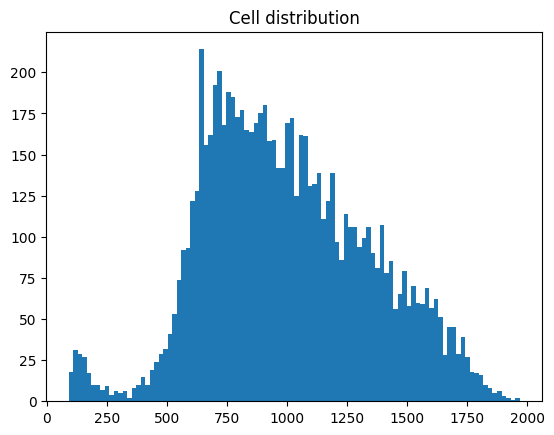

In [16]:
fig, ax = plt.subplots()

ax.hist(cells_dist, bins=100)

plt.title('Cell distribution')
plt.savefig('realistic_cell_dist.svg')

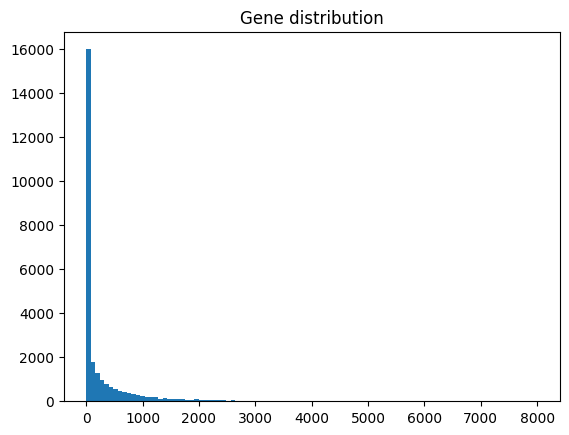

In [17]:
fig, ax = plt.subplots()

ax.hist(gene_dist, bins=100)

plt.title('Gene distribution')
plt.savefig('realistic_gene_dist.svg')

In [18]:
num_cells = 8000
num_genes = 26361

### Problem 2b: Filtering and normalization


According to these distributions, some cells have only a handful of expressed genes. Furthermore, looking at the genes, a good number of them are expressed in only a few cells (if at all!). Does it make sense to perform any analysis on these cells/genes? How reliable will these results be? We'd most likely need to apply some filtering before proceeding with further analyses. How would you go about filtering this data?
Before continuing the analysis, we must filter the data to keep only reliable information. Thus, we will filter out some cells and some low-expressed genes. 

Sequencing depth tells us how many reads of information we counted in our count matrix for a single cell. When comparing gene expression in cells with different sequencing depths, we must account for their total sum and normalize those counts. An easy but effective approach is to normalize expression counts in each cell, to sum up to a number. For single-cell RNAseq data, that number is 10,000. For bulk-RNAseq, that number is 1,000,000, and we know the unit as counts-per-million (CPM). There are more sophisticated methods for normalizing counts that account for mRNA lengths like TPM and other variants.

Observing the distribution of gene expression in different cells, we quickly see that they rarely follow a normal distribution but are heavily skewed. Therefore, we apply a logarithmic transformation to expression values. Using a natural logarithm is a standard procedure for RNAseq, whereas microarray data is already normal-like. 

**Task:**
Filter cells based on the number of genes detected. Keep only 7000 cells.
Filter genes based on the number of cells where found. Keep only 5000 genes. First, determine what those cells and genes are, and then create another expression matrix without them. Performing filtering steps consecutively might give different results, so perform them independently.

Implement a function `normalize_expressions` in the `helper_functions.py`.
Normalize counts in a matrix by log-transforming the expressions. We will add 1 to our expression count and then use a natural logarithm. Pseudo count (+1) ensures that genes with 0 counts will map to 0 after the transformation. Lastly, normalize the gene expressions for each sample so they sum up to 10,000. 

Apply filtering and normalization to the matrix from the previous subproblem and continue with the analysis.

**Note:** By using this filtering, we lose a lot of information. However, working with fewer genes is easier for this exercise while achieving the same results.

**[4 points]**

In [19]:
from helper_functions import filter_matrix, normalize_expressions

In [20]:
filtered_data = filter_matrix(real_data, 642, 461)
normalized_data = normalize_expressions(filtered_data)

In [21]:
print(normalized_data)

                      AAK1  AAMP       AARS       AATF     ABCA7      ABCE1  \
covid_557.4709    0.000000   0.0   0.000000   0.000000  0.000000   0.000000   
HIP044.2538       0.000000   0.0   0.000000   0.000000  0.000000  13.717421   
covid_557.6177    6.993007   0.0   6.993007   0.000000  0.000000   0.000000   
HIP023.321        0.000000   0.0   0.000000  17.699115  0.000000  17.699115   
HIP002.813        0.000000   0.0   0.000000   0.000000  0.000000   0.000000   
...                    ...   ...        ...        ...       ...        ...   
covid_555_1.1700  0.000000   0.0  14.306152   0.000000  0.000000   0.000000   
covid_557.1827    0.000000   0.0   0.000000   0.000000  0.000000   0.000000   
HIP044.1885       0.000000   0.0   0.000000   0.000000  0.000000  15.432099   
covid_559.1316    0.000000   0.0   0.000000   0.000000  0.000000  13.003901   
covid_555_1.2534  0.000000   0.0   0.000000   0.000000  9.852217   0.000000   

                      ABCF1  ABCF2     ABHD13    AB

### Problem 2c: Differential analysis

We want to know how our cells respond to SARS-CoV-2 infection. When a cell is infected, it produces a response by expressing genes that carry out that response, whatever it may be. It can trigger various reactions, such as recruiting other cells, internal signaling to remove the virus, or cell death. We can observe gene expression in healthy cells to find genes with higher or lower expression in COVID-19 patient cells. We will perform differential expression (DE) to confirm their statistical significance.

We will use a simple t-test for the differential expression. The test will give us a p-value for each gene, representing the probability that we will observe such or more extreme results if the null hypothesis is true. In practice, more sophisticated approaches are used, like Willcoxon rank-sum test. Also, some bulk-RNA methods are used in single-cell analysis, such as DESeq2. Sometimes, p-values can give a misleading impression. Therefore, we couple them with information about fold change (FC), calculated as the ratio of the mean expression. In essence, p-values tell us how significant the difference is, while fold change tells us how big the difference in expression is. Plotting $log_2(FC)$ on the x-axis and $-log_{10}(p_{values})$ on the y-axis gives us a volcano plot.


<div>
    <img src=https://training.galaxyproject.org/training-material/topics/transcriptomics/images/rna-seq-viz-with-volcanoplot/volcanoplot.png width=500>
</div>

Image source: [Galaxy Training!](https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/rna-seq-viz-with-volcanoplot/tutorial.html)

**Task:**
Our null hypothesis states there is no differential expression of gene A between healthy and COVID-19 patients.
Use the t-test from the scipy library (*scipy.stats.ttest_ind*) to calculate a p-value for the hypothesis for each gene.

Because we are making a lot of t-test hypothesis tests, we must correct our p-values for false discovery. Use the false discovery rate (FDR) correction function from the statsmodels library (*statsmodels.stats.multitest.fdrcorrection*) to correct p-values.

Calculate the fold change for healthy and COVID-19 patients.
Plot a volcano plot as a scatter plot, where you put $log_2(FC)$ on the x-axis and $-log_{10}(p_{value})$ on the y-axis. Center the x-axis on the plot as shown in the example above. Use a threshold $\pm 2$ for $log_2(FC)$ and $50$ for $-log_{10}(p_{value})$. Color genes above both thresholds, as shown in the plot above. Save the plot in `volcano.svg`.

Colored genes represent differentially expressed genes. Report these genes as a list of strings in a `diff_expressed_genes` variable.

**[5 points]**

In [22]:
import scipy
from statsmodels.stats.multitest import fdrcorrection

In [23]:
# Get healthy and non healthy rows
covid_cells = []
non_covid_cells = []

for i in range(len(normalized_data.index)):
    if normalized_data.index[i][0:5] == 'covid':
        covid_cells.append(i)
    else:
        non_covid_cells.append(i)

In [24]:
gene_dict = {}
num_rows = np.shape(normalized_data)[1]

for i in range(num_rows):
    current_row = normalized_data.values[:, i]
    covid = current_row[covid_cells]
    non_covid = current_row[non_covid_cells]
    res = scipy.stats.ttest_ind(covid, non_covid)
    fold_change = np.mean(covid) / np.mean(non_covid)
    gene_dict[normalized_data.columns[i]] = (res.pvalue, fold_change)

In [25]:
p_vals = [x for (x, _) in gene_dict.values()]
fc = [x for (_, x) in gene_dict.values()]

rejected, corrected = fdrcorrection(p_vals)

fc_log = np.log2(fc)
p_vals_log = -np.log10(corrected)

In [26]:
upregulated = []
gene_keys = list(gene_dict.keys())

for i in range(len(fc_log)):
    if p_vals_log[i] > 50:
        if fc_log[i] >= 2 or fc_log[i] <= -2:
            upregulated.append(gene_keys[i])

print(upregulated)

['ACSL1', 'AQP9', 'C19orf59', 'CCR1', 'CCR2', 'CES1', 'CLU', 'CR1', 'CYP1B1', 'DYSF', 'F13A1', 'FCGR1A', 'FCGR1B', 'IFI27', 'IFI44', 'IFI44L', 'IFI6', 'IFIT1', 'IFIT3', 'IGHG1', 'IGLC3', 'IL8', 'MX1', 'OAS3', 'RNASE2', 'RSAD2', 'S100A12', 'SH2D1B', 'SIGLEC1', 'SOCS3']


In [27]:
upregulated_genes_p, upregulated_genes_fc = [], []
downregulated_genes_p, downregulated_genes_fc = [], []
non_significant_p, non_significant_fc = [], []

for i in range(len(fc_log)):
    if p_vals_log[i] > 50:
        if fc_log[i] >= 2:
            upregulated_genes_p.append(p_vals_log[i])
            upregulated_genes_fc.append(fc_log[i])
        elif fc_log[i] <= -2:
            downregulated_genes_p.append(p_vals_log[i])
            downregulated_genes_fc.append(fc_log[i])
        else:
            non_significant_p.append(p_vals_log[i])
            non_significant_fc.append(fc_log[i])
    else:
        non_significant_p.append(p_vals_log[i])
        non_significant_fc.append(fc_log[i])

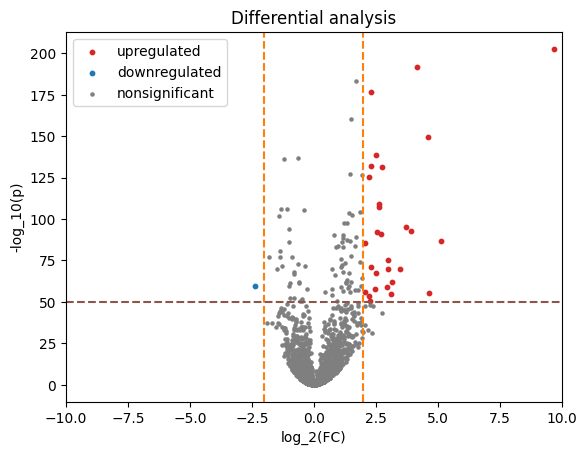

In [28]:
fig, ax = plt.subplots()

ax.scatter(upregulated_genes_fc, upregulated_genes_p, s=10, color='tab:red', label='upregulated')
ax.scatter(downregulated_genes_fc, downregulated_genes_p, s=10, color='tab:blue', label='downregulated')
ax.scatter(non_significant_fc, non_significant_p, s=5, color='tab:grey', label='nonsignificant')
ax.axvline(2, linestyle='--', color='tab:orange')
ax.axvline(-2, linestyle='--', color='tab:orange')
ax.axhline(50, linestyle='--', color='tab:brown')

plt.xlim(-10, 10)

plt.legend()
plt.title('Differential analysis')
plt.xlabel('log_2(FC)')
plt.ylabel('-log_10(p)')
plt.savefig('volcano.svg')

In [29]:
diff_expressed_genes = ['ACSL1', 'AQP9', 'C19orf59', 'CCR1', 'CCR2', 'CES1', 'CLU', 'CR1', 'CYP1B1', 'DYSF',
                        'F13A1', 'FCGR1A', 'FCGR1B', 'IFI27','IFI44', 'IFI44L', 'IFI6', 'IFIT1', 'IFIT3', 'IGHG1',
                        'IGLC3', 'IL8', 'MX1', 'OAS3', 'RNASE2', 'RSAD2', 'S100A12', 'SH2D1B', 'SIGLEC1', 'SOCS3']

Then, answer the following questions:

- Why are we specifically interested in differentially expressed genes?
- In differential expression analysis, the t-test relies on several assumptions. Given these assumptions, would we still obtain meaningful results when using raw, unfiltered, and unnormalized data? Discuss the impacts of both filtering and normalization on the analysis.

Store your answers in the `why_diff_expressed_genes` and `meaningful_diff_expression` variables, respectively.

**[2 points]**

In [30]:
why_diff_expressed_genes = """
Why are we specifically interested in differentially expressed genes?
Changes that happen in upregulated or downregulated genes can help us understand how the diseases might develop (if the genes produce the disease) and that can
help us create cure to combat it.
"""

In [31]:
meaningful_diff_expression = """
Given these assumptions, would we still obtain meaningful results when using raw, unfiltered, and unnormalized data? Discuss the impacts of both filtering and normalization on the analysis.
Probably not, since filtering helps us get rid of data that might not be correct, while normalizing helps us get the data in the same "shape", so that it doesnt differ one sample
from another.
"""

### Problem 2d: Gene Enrichment Analysis

We found some genes that are differentially expressed in COVID-19 patient cells. We want to link them to biological terms so we can reason about the response of cells to infection. Gene enrichment analysis is a method for making that connection. But first, we need some biological terms to link our genes to.

[Gene Ontology](http://geneontology.org/) (GO) is a database that stores annotated gene sets related to some broader function in human cells. It builds hierarchically; therefore, some gene sets might have only a handful of genes and others a few thousand. Check the resource for more information. We have already prepared a JSON file: `data/GO_genesets.json`, containing GO terms and their genes. We will use these as gene sets in enrichment analysis.

**Task:**
Implement a function `hypergeometric_pval` in the file `helper_functions.py` that calculates the p-value according to the hypergeometric distribution as a part of Gene Enrichment Analysis.
You can use the *scipy* library in your implementation.

Calculate the p-value for each gene set from the Gene Ontology `data/GO_genesets.json` file. Use FDR correction to correct these values.
Sort GO terms by their p-values and check the description of a top few ontologies.
Save the description of the highest ranking ontology in the `enriched_GO_term` variable.

Then answer the following questions:
- Search on the internet (e.g., Wikipedia) and reason about the validity of the enriched term. Does your result make sense?

Store0 your answers in the `GO_term_comments` variable.

**[5 points]**

In [32]:
import json

from helper_functions import hypergeometric_pval

In [33]:
with open('data/GO_genesets.json') as d:
    json_data = json.load(d)

In [34]:
genes_data = list(real_data.columns)
p_values = {}

for i in json_data:
    name = json_data[i]['id']

    n = len(diff_expressed_genes)
    N = 5002
    K = len(json_data[i]['genes'])
    k = 0

    for gene in diff_expressed_genes:
        if gene in json_data[i]['genes']:
            k += 1

    p = hypergeometric_pval(N, n, K, k)

    if p > 0:
        p_values[name] = p

rejected_d, corrected_d = fdrcorrection(list(p_values.values()))

In [35]:
i = 0
for name in p_values:
    p_values[name] = corrected_d[i]
    i += 1

sorted_p = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[1], reverse=True)}
print(sorted_p)

{'GO:0005737': np.float64(0.9999999999999999), 'GO:0005634': np.float64(0.9999999999999999), 'GO:0016020': np.float64(0.9999999999999999), 'GO:0005730': np.float64(0.9999999999999999), 'GO:0005813': np.float64(0.9616241897652043), 'GO:0005794': np.float64(0.8953825745710677), 'GO:0008150': np.float64(0.8953825745710677), 'GO:0003682': np.float64(0.8953825745710677), 'GO:0051301': np.float64(0.8892288356855254), 'GO:0015031': np.float64(0.8635082707679671), 'GO:0032991': np.float64(0.8593500584659692), 'GO:0006508': np.float64(0.8350460977941578), 'GO:0007049': np.float64(0.7936806707278674), 'GO:0005783': np.float64(0.761231927699252), 'GO:0006281': np.float64(0.7596183116375884), 'GO:0043005': np.float64(0.7453059770942064), 'GO:0055114': np.float64(0.7140237509803125), 'GO:0006412': np.float64(0.66680136799783), 'GO:0005694': np.float64(0.6626119270918654), 'GO:0005929': np.float64(0.6582211523082824), 'GO:0030496': np.float64(0.6536226916912172), 'GO:0038023': np.float64(0.651776793

In [36]:
print(json_data['GO:0005737']['description'])

cytoplasm


In [37]:
enriched_GO_term = "cytoplasm" # description field of an enriched GO term

In [38]:
GO_term_comments = """
Search on the internet (e.g., Wikipedia) and reason about the validity of the enriched term. Does your result make sense?
It kind of makes sense, since the delition of cytoplasmic tail of the SARS-CoV-2 leads to more infective pseudoviruses.
"""

## Bonus problem: Single-cell data analysis

We now know what a count matrix is and how to create one. However, the real fun begins when we start working with this matrix and applying statistical methods to uncover some interesting facts about the tissue. The methods we learned about in this course have been very bioinformatics-specific. We learned about DNA, alignment algorithms, graph assembly algorithms, etc. But now we have a matrix, and we can reach into other fields of statistical analyses with a wide range of tools. Machine learning is one of the most powerful toolboxes for finding structure in these kinds of matrices.

Single-cell data analysis usually involves many predefined steps that include using a mix of bioinformatics-specific procedures and more general machine-learning techniques, e.g., dimensionality reduction and clustering. Of course, we won't go into machine learning here -- there are entire courses dedicated to machine learning -- but we'll follow a simple tutorial to get our feet wet and get a feeling for what can be done with the count matrices we've created here. You will repeat some of the steps done in Problem 2.

In this exercise, we'll continue exploring the SARS-CoV-2 count matrix we started working with in Problem 2 (`data/homework5.h5ad`) and run a standard analysis pipeline.
We'll be using scanpy. Scanpy is a Python library for single-cell data analysis that provides a friendly and easy interface for working with single-cell data. Scanpy also comes complete with several helpful tutorials that are very useful when getting started. Follow this beginner clustering tutorial at https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html, and submit the required images.

In diff expression we need to define two groups. List two different 

You're required to submit three images, each worth 5 points:
1. PCA (`sc_analysis_pca.svg`)
2. UMAP or t-SNE colored by clusters (`sc_analysis_clusters.svg`)
3. UMAP or t-SNE colored by some kind of differential expression (`sc_analysis_deg.svg`)

**[15 points]**

Then answer the following questions:
- When plotting the results of t-SNE, you can observe different clusters of cells. What do they represent?

Store your answers in the `tsne_clusters` variable.

**[1 point]**

In [39]:
tsne_clusters = """
When plotting the results of t-SNE, you can observe different clusters of cells. What do they represent?
"""